In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import math

from numbers import Number
from math import pi
from torch import Tensor

_log_2 = math.log(2)
_sqrt_pi = math.sqrt(pi)
_inv_sqrt_pi = 1 / _sqrt_pi
_inv_sqrt_2pi = (2 * pi) ** -0.5
_neg_inv_sqrt_2 = -(2**-0.5)
_log_sqrt_2pi = math.log(2 * pi) / 2

### Bayesian Optimization

Bayesian optimisation, operates in two main steps.. 
Assume we want to find our optimum in N trials.

<b> for </b> i=0: N-1:

<span style="color:blue"> <b> Step I </b> </span> -> Fit the GP model to the current dataset $D_{i}$ by $\min_{\theta}\mathcal{J}(\theta)$

<span style="color:blue"> <b> Step II </b> </span> -> Find q points by solving $$x_{1:q}^{(new)} = \arg\max_{x_{1:q}} a_{\text{q-type}}(x_{1:q} | \mathcal{D_{i}})$$
Evaluate new inputs by querying the black-box to acquire $y_{1:q}^{(new)} = f(x_{1:q}^{(new)})$.

Update the dataset creating $D_{i+1} = D_{i} \cup \{ x_{l}^{(new)}, y_{l}^{(new)} \}_{l=1}^{q}$

### Set the Gaussian Process

<b> Definition </b>: A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.
$$ m(x) = \mathbb{E}[f(x)], \space \space k(x,x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))].$$
$$ f(x) \sim \mathcal{GP}(m(x), k(x,x')).$$

<b> Assumptions </b>: 
    $$ y = f(x) + \epsilon, \epsilon \sim \mathcal{N}(0,\sigma_{n}^{2}).$$
    $$ f(x) \sim \mathcal{GP}(m(x), k(x,x')).$$
    
<b> Marginal Likelihood </b>:
    $$ p(y | X) = \int p(y, f | X) df = \int p(y | f, X) p(f | X)df.$$
    
<b> Likelihood </b>:
    $$ p(y | f, X) = \mathcal{N}(f, \sigma_{n}^{2}I).$$
    
<b> Prior </b>: 
    $$ p(f | X) = N(0, K_{\theta}).$$
    
<span style="color:red"> <b>Exact solution to the marginal likelihood </b> </span>:
    $$ \log p(y | X) = - \dfrac{1}{2}y_{T}[K_{\theta} + \sigma_{n}^{2}I]^{-1}y - \dfrac{1}{2}\log |K_{\theta} + \sigma_{n}^{2}I| - cnst.$$
    
Our scope is to maximize the marginal likelihood in order to find the parameters of the Gaussian Process.

In [2]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



def train_gp(model, likelihood, train_x, train_y, training_iter=1):
    
    model.train()
    likelihood.train()
    
    # Includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()

        optimizer.step()
    return model

In [3]:
def plot_prior(cov, n_samples, kname=None, ax=None):
    if ax is None:
        ax = plt.subplot()
        
    samples = np.random.multivariate_normal(np.zeros(len(x)), cov, size=n_samples)
    
    for i in range(n_samples):
        ax.plot(x.flatten(), samples[i])
    ax.plot([0,1], [0,0], c='r', linewidth=2)
    ax.fill_between([0,1], [-2, 2], [2,2], alpha=.1, color='r')
    lim = max(np.max(np.abs(samples)), 2) * 1.2
    ax.set_ylim(-lim, lim)
    ax.set_xlim(0,1)
    ax.grid(False)
    return ax

In [47]:
def plot_posterior(model, preds, tensor_samples_x, tensor_samples_y, train_x, train_y):
    
    mean = outputs.mean.detach().numpy().flatten()
    stddev = outputs.stddev.detach().numpy().flatten()
    
    ax = plt.subplot()

    ax.plot(train_x.flatten(), train_y.flatten(), linestyle="dotted", label=r"$f(x) = sin(x * 2 \pi) + \epsilon$")
    ax.plot(train_x.flatten(), mean, label='Mean prediction')
    
    ax.fill_between(train_x.flatten(), mean - 2 * stddev, mean + 2 * stddev, alpha=.2, color='orange', label=r"95% confidence interval")
    ax.scatter(tensor_samples_x, tensor_samples_y, label="Observations")
    
    ax.legend()
    ax.grid(False)
    
    return ax

#### Observed data
Define our noisy function $f$

In [5]:
train_x = torch.linspace(0, 1, 100)

def f(x):
    return torch.sin(x * (2 * math.pi)) + torch.randn(x.size()) * 0.2
train_y = f(train_x)

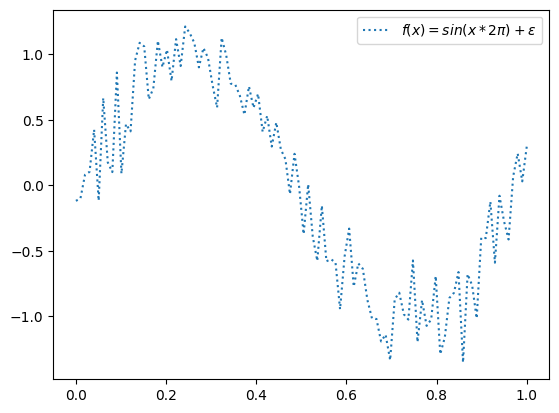

In [46]:
plt.plot(train_x, train_y, linestyle="dotted", label=r"$f(x) = sin(x * 2 \pi) + \epsilon$")
plt.legend()
plt.show()

#### Evolution of Posterior with the addition of samples

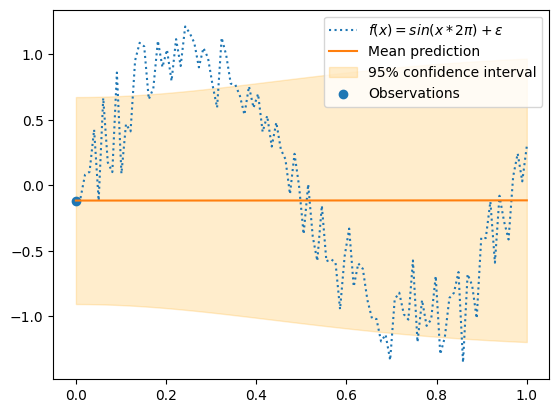

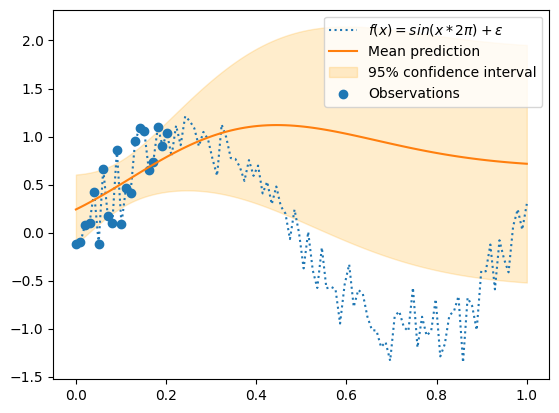

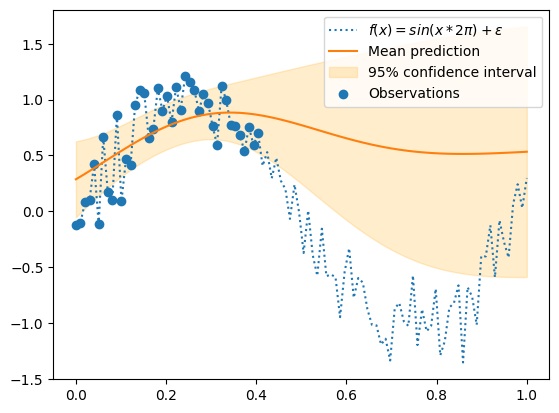

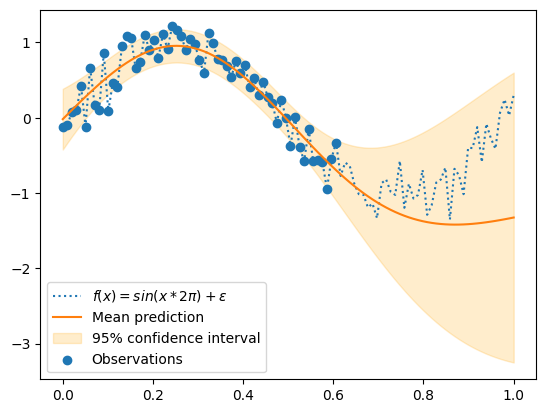

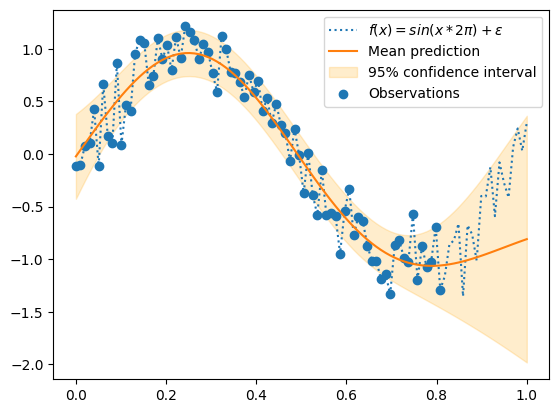

In [48]:
x_collected = []
y_collected = []


## Sequentially add data, train the GP and predict in unseen data.
for c, (x_i, y_i) in enumerate(zip(train_x, train_y)):
    
    ## 1st step of the BO - Fit GP
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    x_collected.append(x_i)
    y_collected.append(y_i)
    
    tensor_x_samples = torch.tensor(x_collected)
    tensor_y_samples = torch.tensor(y_collected)
    
    model = ExactGPModel(torch.tensor(x_collected), torch.tensor(y_collected), likelihood)
    model.train()
    model = train_gp(model, likelihood, torch.tensor(x_collected), torch.tensor(y_collected), training_iter=10)
    model.eval()
    
    outputs = model(train_x)
    if c % 20 == 0:
        plot_posterior(model, outputs, tensor_x_samples, tensor_y_samples, train_x, train_y)
        plt.show()

We see how the variance in the predictions of the Gaussian Process changes with the addition of new samples.

#### Expected Improvement

In order to optimize expected improvement, we need first to write it as a NN module. Torch NN offers the necessary utilities in order to optimize a function. Expected Improvement can be simply written as a Neural Net that takes x and uses ReLU with the best value to derive the expected improvement. ReLU is differentiable in Pytorch and hence we can optimize it with different optimizers like Adam or Stochiastic Gradient Descent etc.

If we can't derive the gradients for the acquisition function we can use 2 point estimation of the derivatives like in LBFGS. Although if the acquisition function is implemented in Pytorch, we can immediately calculate the gradients for that function.

#### Deriviation for Expected Improvement
full deriviation : http://ash-aldujaili.github.io/blog/2018/02/01/ei/

we are interested in quantifying the improvement over $f^{*}$
 we will have if we sample a point x
 . Mathematically, the improvement at x
 can be expressed as follows

$$I(x)=max(f^{*}−Y,0)$$ where $Y$ is the random variable $\sim \mathcal{N}(\mu,\sigma^{2})$ that corresponds to the function value at $x$. Since $I$ is a random variable, one can consider the average (expected) improvement (EI) to assess x:

$$EI(x)=E_{Y \sim \mathcal{N}(\mu,\sigma^{2})}[I(x)]$$
With the reparameterization trick, $Y=\mu+\sigma \epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$, we have:
$$EI(x)=E_{\epsilon \sim \mathcal{N}(0,1)}[I(x)]$$ which can be written as (from linearity of integral, and the definition of $\dfrac{d}{d\epsilon} e^{-\epsilon^{2} / 2}$ derivative )

$$EI(x)=\int_{-\infty}^{+\infty}I(x)\phi(\epsilon)d\epsilon$$

$$EI(x)=\int_{-\infty}^{(f^{*} -\mu)/\sigma}(f^{*} - \mu - \sigma\epsilon)\phi(\epsilon)d\epsilon$$

$$EI(x)=(f^{*} - \mu) \Phi(\dfrac{f^{*} - \mu}{\sigma}) - \sigma \int_{-\infty}^{(f^{*} -\mu)/\sigma}\epsilon\phi(\epsilon)d\epsilon$$

$$\cdots$$


$$EI(x)=(f^{∗}−\mu)\Phi(\dfrac{f^{∗}−\mu}{\sigma})+\sigma \phi(\dfrac{f^{∗}−\mu}{\sigma})$$
where $\phi$, $\Phi$ are the PDF, CDF of standard normal distribution, respectively.

#### Helper functions to get mathematics constants in tensors

In [13]:
def get_constants_like(values, ref):
    return get_constants(values, device=ref.device, dtype=ref.dtype)

def get_constants(values, device, dtype):
    r"""Returns scalar-valued Tensors containing each of the given constants.
    Used to expedite tensor operations involving scalar arithmetic. Note that
    the returned Tensors should not be modified in-place."""
    if isinstance(values, Number):
        return torch.full((), values, dtype=dtype, device=device)

    return tuple(torch.full((), val, dtype=dtype, device=device) for val in values)


In [14]:
def _scaled_improvement(mean: Tensor, sigma: Tensor, best_f: Tensor, maximize: bool) -> Tensor:
    """Returns `u = (mean - best_f) / sigma`, -u if maximize == True."""
    u = (mean - best_f) / sigma
    return u if maximize else -u

def phi(x: Tensor) -> Tensor:
    r"""Standard normal PDF."""
    inv_sqrt_2pi, neg_half = get_constants_like((_inv_sqrt_2pi, -0.5), x)
    return inv_sqrt_2pi * (neg_half * x.square()).exp()

def ndtr(x: Tensor) -> Tensor:
    r"""Standard normal CDF."""
    half, neg_inv_sqrt_2 = get_constants_like((0.5, _neg_inv_sqrt_2), x)
    return half * torch.erfc(neg_inv_sqrt_2 * x)

def calculate_expected_improvement(u):
    return phi(u) + u * ndtr(u)


class ExpectedImprovement(nn.Module):
    
    def __init__(self, best_f, model):
        super().__init__()
        self.best_f = torch.as_tensor(best_f)
        self.model = model
        self.maximize = True
        
    def forward(self, x):
        
        # ExpectedImprovement = ReLU[(f(x) - f(x_i^{+}))]
        outputs = self.model(x)
        mean, sigma = outputs.mean, outputs.stddev
        
        u = _scaled_improvement(mean, sigma, self.best_f, self.maximize)
        return calculate_expected_improvement(u)

#### Optimize the Acquisition function

Lets say now that the best value currently is 0.5. We would like to optimize the acquisition function (Expected Improvement) to find the next point to evaluate.

In [15]:
n_iter = 50
e_imp = ExpectedImprovement(best_f=0.5, model=model)

x = torch.tensor(0.0, requires_grad=True)
optimizer = torch.optim.Adam([x], lr=0.1)

for _ in range(n_iter):
    
    optimizer.zero_grad()
    
    loss = -e_imp(x.reshape(1)) #maximize the acquisition function
    loss.backward()
    
    optimizer.step()
    
optimal_solution = x.item()
max_objective_value = e_imp(x.reshape(1)).item()

print("Optimal solution:", optimal_solution)
print("Max objective value:", max_objective_value)

Optimal solution: 0.2576795816421509
Max objective value: 4.254962921142578


#### Putting it all together

We need to define constraints in order our points to be inside the interval during the optimization.

In [16]:
def constraint_function(x):
    return x - 1.0

# Define the projection onto the feasible region
def project_feasible_region(x):
    return torch.clamp(x, min=0.0)

In [17]:
def propose_next_point(model, best_f, bounds, n_restarts=10):
    
    n_iter = 50
    e_imp = ExpectedImprovement(best_f=best_f, model=model)

    points = []
    objective_values = []
    
    for starting_point in np.random.uniform(bounds[0], bounds[1], size=n_restarts):
        
        x = torch.tensor(starting_point, requires_grad=True, dtype=torch.float32)
        optimizer = torch.optim.Adam([x], lr=0.001)

        for _ in range(n_iter):

            optimizer.zero_grad()

            loss = e_imp(x.reshape(1)) # maximize the acquisition function

            constraint = constraint_function(x)

            penalty = 1e5 * constraint ** 2

            total_loss = loss + penalty

            total_loss.backward()

            optimizer.step()

            x.data = project_feasible_region(x.data)

        optimal_solution = x.item()
        max_objective_value = e_imp(x.reshape(1)).item()
        
        points.append(optimal_solution)
        objective_values.append(max_objective_value)
        
    return points[np.argmax(objective_values)]

Iteration :  0 
---------------



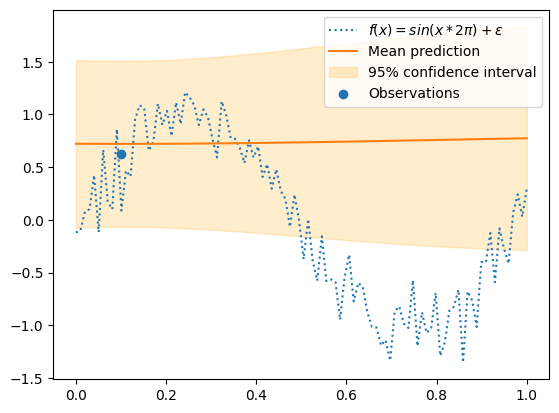

Iteration :  10 
---------------



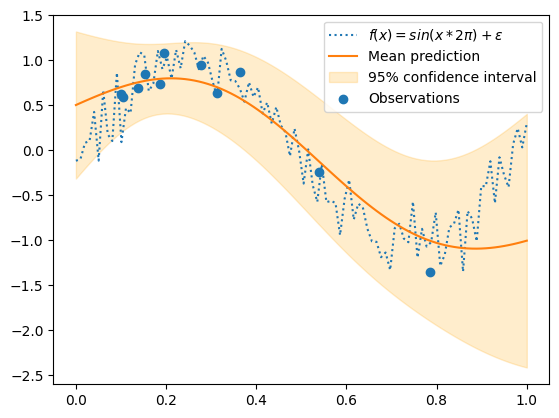

Iteration :  20 
---------------



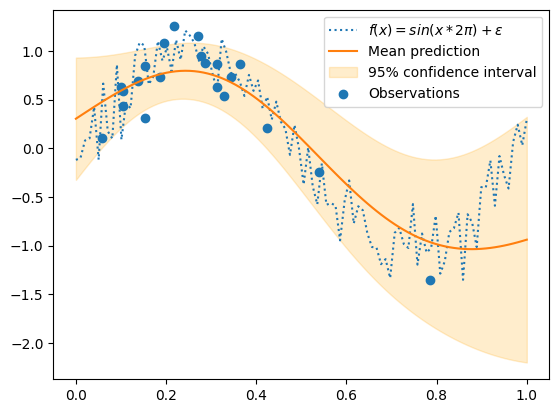

Iteration :  30 
---------------



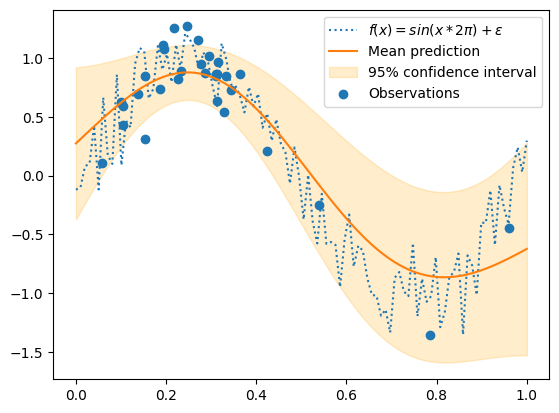

In [49]:
x_init = torch.tensor([0.1])
y_init = f(x_init)

# Start with a random guess
x_collected = [x_init]
y_collected = [y_init]

# Run optimization loop for 100 iterations
n_steps = 31

# Sequentially add data, train the GP and evaluate in the next best x.
for n_iter in range(n_steps):
    
    ## 1st step of the BO - Fit GP
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    tensor_x_samples = torch.tensor(x_collected)
    tensor_y_samples = torch.tensor(y_collected)
    
    model = ExactGPModel(torch.tensor(x_collected), torch.tensor(y_collected), likelihood)
    model.train()
    model = train_gp(model, likelihood, torch.tensor(x_collected), torch.tensor(y_collected), training_iter=10)
    model.eval()
    
    outputs = model(train_x)
    
    ## 2nd step of the BO - Find next best point
    best_f = tensor_y_samples.max() #our current best_f is f(x)
    
    # Optimize the acquisition function to predict the next best point
    x_next = torch.tensor(
                propose_next_point(model=model, 
                    best_f=best_f,
                    bounds=(0,1),
                    n_restarts=5)
        ).reshape(1)
    
    # Evaluate on the next best point and add it to the collected set
    y_next = f(x_next)
    
    x_collected.append(x_next)
    y_collected.append(y_next)
    
    if n_iter % 10 == 0:
        print('Iteration : ', n_iter, '\n---------------\n')
        plot_posterior(model, outputs, tensor_x_samples, tensor_y_samples, train_x, train_y)
        plt.show()

In [43]:
print('Best f(x): ', torch.tensor(y_collected).max().item())
print('Optimal point x:', x_collected[torch.tensor(y_collected).argmax().item()].item())

Best f(x):  1.503469467163086
Optimal point x: 0.15765799582004547


In [44]:
print('Max y from training set: ', train_y.max().item())

Max y from training set:  1.2116564512252808
